In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms

import os
from PIL import Image
import matplotlib.pyplot as plt

import json

Defining the model

In [2]:
def conv_block(in_channels, out_channels, activation=False, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), nn.BatchNorm2d(out_channels)]
    if activation: layers.append(nn.ReLU(inplace=True))
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet34(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=7, stride=1, padding=4), nn.BatchNorm2d(64),nn.MaxPool2d(2), nn.ReLU(inplace=True))
        self.res1 = nn.Sequential(conv_block(64, 64,activation=True), conv_block(64, 64))
        self.res2 = nn.Sequential(conv_block(64, 64,activation=True), conv_block(64, 64))
        self.res3 = nn.Sequential(conv_block(64, 64,activation=True), conv_block(64, 64))
        self.downsample1=nn.Sequential(conv_block(64, 128,pool=True)) 
        self.res4 = nn.Sequential(conv_block(64, 128,activation=True, pool=True), conv_block(128,128))
        self.res5 = nn.Sequential(conv_block(128, 128,activation=True), conv_block(128, 128))
        self.res6 = nn.Sequential(conv_block(128, 128,activation=True), conv_block(128, 128))
        self.res7 = nn.Sequential(conv_block(128, 128,activation=True), conv_block(128, 128))
        self.res8 = nn.Sequential(conv_block(128, 256,activation=True, pool=True), conv_block(256,256))
        self.downsample2 = nn.Sequential(conv_block(128, 256,pool=True))
        self.res9 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res10 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res11 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res12 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res13 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res14 = nn.Sequential(conv_block(256, 512,activation=True, pool=True), conv_block(512,512))
        
        self.downsample3 = nn.Sequential(conv_block(256, 512,pool=True))
        self.res15 = nn.Sequential(conv_block(512, 512,activation=True), conv_block(512, 512))
        self.res16 = nn.Sequential(conv_block(512, 512,activation=True), conv_block(512, 512,activation=True))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d((1,1)), nn.Flatten(), nn.Dropout(0.17), nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.res1(out) + out
        out = self.res2(out) + out
        out = self.res3(out) + out
        out = self.downsample1(out) +self.res4(out)
        out = self.res5(out) + out
        out = self.res6(out) + out
        out = self.res7(out) + out
        out = self.downsample2(out) +self.res8(out)
        out = self.res9(out) + out
        out = self.res10(out) + out
        out = self.res11(out) + out
        out = self.res12(out) + out
        out = self.res13(out) + out
        out = self.downsample3(out) + self.res14(out) 
        out = self.res15(out) + out
        out = self.res16(out) + out
        out = self.classifier(out)
        return (out)

Making list of the classes

In [16]:
# Read JSON file and convert to Python object
with open('bird_map.json', 'r') as json_file:
    bird_name_map = json.load(json_file)

Choosing the device for the model

In [4]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [5]:
device=get_default_device()
print(device)

cuda


Loading the model

In [6]:
class BirdResnet(nn.Module):
    def __init__(self):
        super().__init__()
        # Using the pretrained model
        self.network = model
    
    def forward(self, xb):
        return (self.network(xb))

In [18]:
# Get the current working directory
current_directory = os.getcwd()

# Construct the path to your file
file_path = os.path.join(current_directory, 'trained-models', 'bird-resnet34best.pth')

model = to_device(ResNet34(3,450), device)

model=(BirdResnet())

model.load_state_dict(torch.load(file_path, map_location=torch.device(device)))

<All keys matched successfully>

In [19]:
stats = ((0.4758, 0.4685, 0.3870), (0.2376, 0.2282, 0.2475))
def predict_image(path, model):
    im=Image.open(path)
    # resizing images then converting image to tensor, normalizing the tensors
    transform = transforms.Compose([transforms.Resize((250,250)),transforms.ToTensor(),transforms.Normalize(*stats,inplace=True)]) 
    img=transform(im)
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    model.eval()
    with torch.no_grad():
        yb = model(xb)
    # Pick index with highest probability
    prob=nn.Softmax(dim=1)
    yb=prob(yb)
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    print('Predicted:', bird_name_map.get(str(preds[0].item())), 'with a probability of', str(round(torch.max(yb).item(), 4)*100)+'%')
    plt.imshow(im)
    plt.show()

Prediction of single images

Predicted: Puffin with a probability of 100.0%


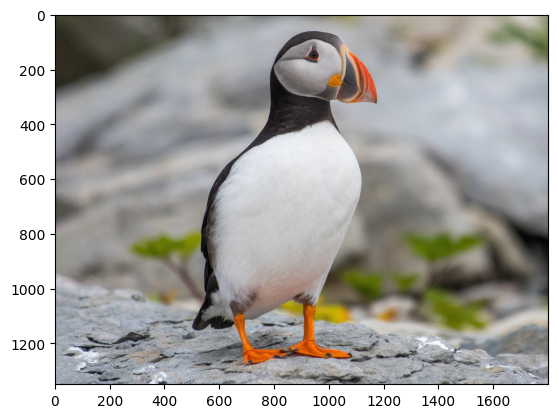

Predicted: Felsentaube with a probability of 99.99%


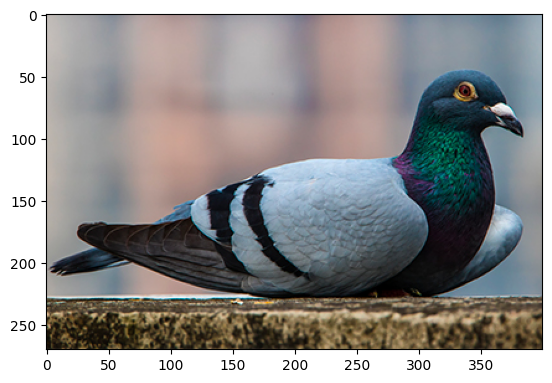

In [20]:
# enter the path of the folder containing the images
current_directory = os.getcwd()

predict_image(os.path.join(current_directory, 'test-data', 'puffin.jpeg'), model)


predict_image(os.path.join(current_directory, 'test-data', 'taube.jpg'), model)

Prediction of images in a folder

In [10]:
# enter the path of the folder containing the images
current_directory = os.getcwd()

# Construct the path to your file
path = os.path.join(current_directory, 'trained-models')


for file in os.listdir(path):

  if file.endswith('jpg') or file.endswith('png') or file.endswith('webp') or file.endswith('jpeg'):

    predict_image('/content/'+file, model)